In [3]:
using LinearAlgebra
using Plots, Plots.PlotMeasures
using Colors
using LaTeXStrings
using FFMPEG

In [35]:
# define arguments
fov = 20           # fov (cm)
N = 128            # nominal matrix size
nspokes = 5        # number of lps spokes
nechoes = 2        # number of echoes
tseg = 1120        # time/segment (us)
trf = 20           # time/rf pulse (us)
fa = 4             # rf flip angle (deg)
gmax = 4           # max gradient amplitude (G/cm)
smax = 4000        # max slew rate (G/cm/s)
dt = 4             # raster time (us)
gam = 4258         # GMR of H+ (Hz/G)
T2 = 10e3          # T2 (us)

10000.0

In [ ]:
# check that segment/rf widths are valid with given raster time
if tseg % dt != 0
    error("tseg must be divisible by raster time")
end
if trf % dt != 0
    error("trf must be divisible by raster time")
end

# calculate loop velocity
om = 2 * pi / (nspokes * tseg * 1e-6)

# calculate gradient amplitude & slew rate
g_amp = pi * N / gam / (tseg * 1e-6) / (nspokes * fov * 2 * sin(pi / nspokes))
s_amp = om * g_amp

# calculate ramp-up
nramp = ceil(Int, g_amp / smax / (dt * 1e-6))
ramp_up = range(0, stop=1, length=nramp)
nramp = length(ramp_up)

# calculate segment length and sample array
nseg = round(Int, tseg / dt)
n = 0:(1+nechoes) * nspokes * nseg - 1

# construct normal gradients
gx = g_amp .* cos.(om .* n .* dt .* 1e-6)
gy = g_amp .* sin.(om .* n .* dt .* 1e-6)

# calculate k-space trajectory
kx = zeros((1+nechoes) * nspokes * nseg, nspokes)
ky = zeros((1+nechoes) * nspokes * nseg, nspokes)
magS = zeros((1+nechoes) * nspokes * nseg, nspokes)
for v in 1:nspokes
    gx_v = circshift(gx, -(v-1)*nseg)[(v-1)*nseg+1:end]
    gy_v = circshift(gy, -(v-1)*nseg)[(v-1)*nseg+1:end]
    kx[(v-1)*nseg+1:end, v] = gam * dt * cumsum(gx_v) * 1e-6
    ky[(v-1)*nseg+1:end, v] = gam * dt * cumsum(gy_v) * 1e-6

    # estimate the signal magnitude for each echo
    magS[(v-1)*nseg+1:end, v] = exp.(-2*sqrt.(kx[(v-1)*nseg+1:end, v] .^ 2 .+ ky[(v-1)*nseg+1:end, v] .^ 2)) .* exp.(-(0:length(gx_v)-1) .* dt ./ T2)
end
kmax = maximum(sqrt.(kx.^2 + ky.^2))

# construct polygon gradients
g_amp_poly = N / fov / 2 / (gam * nseg * dt * 1e-6)
nramp_poly = ceil(Int, g_amp_poly / smax / (dt * 1e-6))
gx_amp_ip1 = g_amp_poly
gy_amp_ip1 = 0.0
gx_poly = Float64[]
gy_poly = Float64[]
for i in 1:(1+nechoes)*nspokes
    gx_amp_i = gx_amp_ip1
    gx_amp_ip1 = g_amp_poly * cos(om * nseg * i * dt * 1e-6)
    append!(gx_poly, vcat(fill(gx_amp_i, nseg), range(gx_amp_i, stop=gx_amp_ip1, length=nramp_poly)))
    
    gy_amp_i = gy_amp_ip1
    gy_amp_ip1 = g_amp_poly * sin(om * nseg * i * dt * 1e-6)
    append!(gy_poly, vcat(fill(gy_amp_i, nseg), range(gy_amp_i, stop=gy_amp_ip1, length=nramp_poly)))
end

# calculate k-space trajectory for polygon
len_poly = (1+nechoes) * nspokes * (nseg + nramp_poly)
kx_poly = zeros(len_poly, nspokes)
ky_poly = zeros(len_poly, nspokes)
magS_poly = zeros(len_poly, nspokes)
for v in 1:nspokes
    gx_poly_v = circshift(gx_poly, -(v - 1) * (nseg + nramp_poly))[(v-1)*(nseg+nramp_poly)+1:end]
    gy_poly_v = circshift(gy_poly, -(v - 1) * (nseg + nramp_poly))[(v-1)*(nseg+nramp_poly)+1:end]
    kx_poly[(v-1)*(nseg+nramp_poly)+1:end, v] = gam * dt * cumsum(gx_poly_v) * 1e-6
    ky_poly[(v-1)*(nseg+nramp_poly)+1:end, v] = gam * dt * cumsum(gy_poly_v) * 1e-6

    # estimate the signal magnitude for each echo
    magS_poly[(v-1)*(nseg+nramp_poly)+1:end, v] = exp.(-2*sqrt.(kx_poly[(v-1)*(nseg+nramp_poly)+1:end, v] .^ 2 .+ ky_poly[(v-1)*(nseg+nramp_poly)+1:end, v] .^ 2)) .* exp.(-(0:length(gx_poly_v)-1) .* dt ./ T2)
end
kmax_poly = maximum(sqrt.(kx_poly.^2 + ky_poly.^2))

# calculate rf amplitude
rf_amp = fa / (360 * gam * trf) # (G)

# construct rf burst pulse
nrf = round(Int, trf / dt)
n = 0:(nspokes-1)*nseg + nrf - 1
rf = rf_amp .* ((mod.(n, nseg) .< nrf) .& (n .< nspokes*nseg))
rf = vcat(rf, zeros((1+nechoes) * nspokes * nseg - length(rf)))

# Color definitions (replace hex2rgb with RGB values or use Colors.jl if needed)
red = RGB(0x9A/255, 0x33/255, 0x24/255)
orange = RGB(0xD8/255, 0x60/255, 0x18/255)
green = RGB(0x75/255, 0x98/255, 0x8d/255)
teal = RGB(0x00/255, 0xB2/255, 0xA9/255)
blue = RGB(0x2F/255, 0x65/255, 0xA7/255)
dblue = RGB(0x00/255, 0x27/255, 0x4C/255)
amethyst = RGB(0x70/255, 0x20/255, 0x82/255)
maize = RGB(0xFF/255, 0xCB/255, 0x05/255)
rmspec = [maize .* (i/(nspokes-1)) + red .* (1-i/(nspokes-1)) for i in 0:nspokes-2];


# Plot the whole end sequence

In [59]:
# k-space cutoff
kcutoff = 0.5;

# get the time for the section
t = (0:(1+nechoes)*nspokes*nseg+2*nramp-1) * dt

# append the ramps to the gradients
gx_1 = vcat(gx[1] * ramp_up, gx, gx[end] * reverse(ramp_up))
gy_1 = vcat(gy[1] * ramp_up, gy, gy[end] * reverse(ramp_up))
rf_1 = vcat(zeros(nramp), rf, zeros(nramp))
kx_1 = vcat(zeros(nramp, nspokes), kx, kx[end, :]' .* ones(nramp, nspokes))
ky_1 = vcat(zeros(nramp, nspokes), ky, ky[end, :]' .* ones(nramp, nspokes))
magS_1 = vcat(zeros(nramp, nspokes), magS, magS[end, :]' .* ones(nramp, nspokes))

# create the acquisition window waveform
acq = (sqrt.(kx_1 .^ 2 .+ ky_1 .^ 2) .< kcutoff * N / fov / 2) .* ((1:size(kx_1, 1)) .- nseg * (0:nspokes-1)' .>= nramp)
acq = sum(1 * acq, dims=2)

# create the animation
#anim = @animate for i in nramp:10:(nechoes+1)*nspokes*nseg+nramp # full sequence
anim = @animate for i in nramp:10:round(Int,(nspokes-0.5)*nseg+nramp) # fID only
#anim = @animate for i in round(Int,(nspokes-0.5)*nseg+nramp):10:round(Int,(2*nspokes-0.5)*nseg+nramp) # 1st GRE only
#anim = @animate for i in round(Int,(2*nspokes-0.5)*nseg+nramp):10:round(Int,((nechoes+1)*nspokes)*nseg+nramp) # subsequent GREs only

    # plot the gradients and rf
    pseq = plot(t, gx_1 / g_amp,
        xlim=(0, maximum(t)), ylim=(-1.1, 1.1),
        title=false,
        color=dblue,
        label=L"g_x",
        xticks=false, yticks=false,
        xlabel="", ylabel=L"")
    plot!(pseq,
        t, gy_1 / g_amp,
        color=dblue,
        line=:dash,
        label=L"g_y",)
    plot!(pseq,
        t, rf_1 / rf_amp,
        title="LPS Pulse Sequence",
        color=red,
        label=L"RF",
        xticks=false, yticks=false,
        xlabel="", ylabel="")

    # plot the magnitude signal and fill under the curve
    pms = plot(t[1:i], magS_1[1:i, 1],
        xlim=(0, maximum(t)), ylim=(0, 1.1 * maximum(magS_1)),
        title="Signal Magnitude",
        color=blue,
        label=false,
        xticks=false, yticks=false,
        xlabel="Time",
        fill=(0, :auto))
    for v in 2:nspokes
        plot!(pms,
            t[1:i], magS_1[1:i, v],
            color=rmspec[v-1],
            label=false,
            fill=(0, :auto))
    end
    plot!(pms,
        t[1:i], acq[1:i, 1],
        color=:green,
        alpha=0.15,
        label="ACQ",
        fill=(0, :auto))

    # plot moving time indicator
    vline!(pseq, [t[i]], line=(:black, :dash), label=false)
    vline!(pms, [t[i]], line=(:black, :dash), label=false)

    # plot the kspace trajectory for each spoke
    pks = plot(cos.(0:0.01:2*pi) .* N / fov / 2 * kcutoff,
        sin.(0:0.01:2*pi) .* N / fov / 2 * kcutoff,
        xlim=(-1.1 * kmax, 1.1 * kmax),
        ylim=(-1.1 * kmax, 1.1 * kmax),
        aspect_ratio=1,
        xticks=false, yticks=false,
        xlabel=L"k_x", ylabel=L"k_y",
        title="K-space Trajectory",
        color=green,
        label=false,
        fill=(0, :auto),  # fill the circle to the center
        alpha=0.15)
    annotate!(pks,
        (0.5 + (N / fov / 2 * kcutoff / (kmax * 1.1)) / 1.75,
            0.5 - (N / fov / 2 * kcutoff / (kmax * 1.1)) / 1.75),
        text(L"\frac{N}{2FOV}", green, :center, 12))
    plot!(pks, kx_1[1:i, 1], ky_1[1:i, 1],
        color=blue,
        label=false)
    scatter!(pks,
        [kx_1[i, 1]], [ky_1[i, 1]],
        marker=:star,
        color=blue, markerstrokecolor=:transparent,
        label=false)
    for v in 2:nspokes
        if i > (v - 1) * nseg + nramp
            plot!(pks,
                kx_1[1:i, v], ky_1[1:i, v],
                color=rmspec[v-1],
                label=false)
            scatter!(pks,
                [kx_1[i, v]], [ky_1[i, v]],
                marker=:star,
                color=rmspec[v-1], markerstrokecolor=:transparent,
                label=false)
        end
    end

    # combine the pulse sequence plots into a tall stack
    ptime = plot(
        pseq, pms,
        layout=grid(2, 1, heights=[0.7, 0.3]),
        linkx=true,
        margin=3mm,
        bottom_margin=5mm,
        left_margin=8mm,
        right_margin=2mm,
    )

    # compact k-space trajectory plot
    pks = plot(pks,
        margin=5mm,
        bottom_margin=5mm,
        left_margin=8mm,
        right_margin=2mm,
    )

    # final combined layout: sequence stack + k-space
    plot(
        ptime, pks,
        layout=grid(1, 2, widths=[0.6, 0.4]),
        size=(1200, 450),
        margin=2mm,
        bottom_margin=8mm,
        left_margin=10mm,
        right_margin=5mm,
    )

end


Animation("/tmp/jl_gmPh5F", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000118.png", "000119.png", "000120.png", "000121.png", "000122.png", "000123.png", "000124.png", "000125.png", "000126.png", "000127.png"])

┌ Info: Saved animation to /home/djfrey/code/projects/lps_figures/compiled_figures/lps_FIDonly_0.5cutoff_2echo.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/gYkEG/src/animation.jl:156


Plots.AnimatedGif("/home/djfrey/code/projects/lps_figures/compiled_figures/lps_FIDonly_0.5cutoff_2echo.gif")
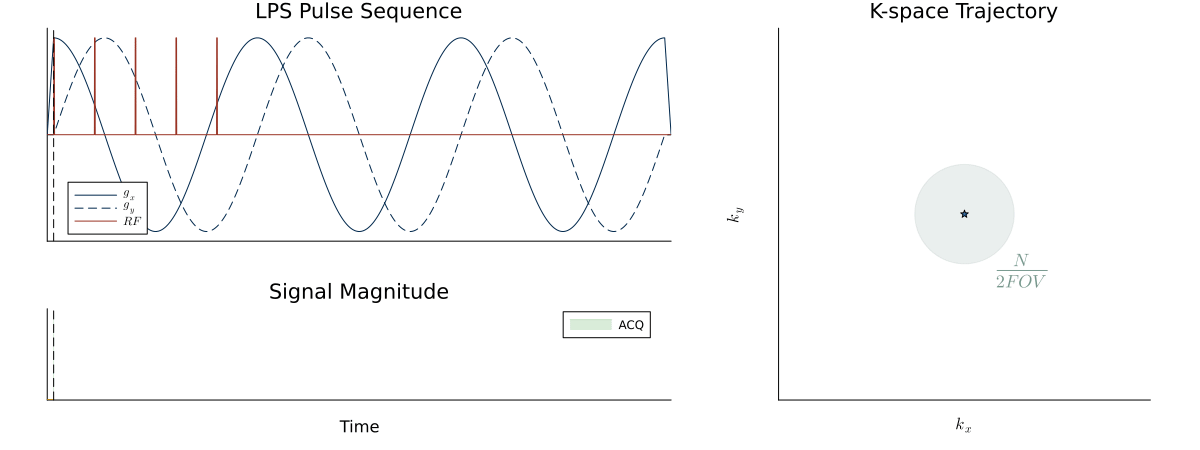

In [60]:

gif(anim, "./compiled_figures/lps_FIDonly_0.5cutoff_2echo.gif", fps=30, loop=-1)